In [1]:
import numpy as np
import torch
import scipy
import time

import sys
sys.path.insert(1, '/home/suarez08/PhD_PINNs/PIPS_framework')
from sobolev import Sobolev
from solver import Solver
from utils import matmul
from diffeomorphisms import hyper_rect
import surrogates
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [3]:
# Tests
# a=-1.0, b=1.0, q=3, sob_2d(deg=30), sob_1d(deg=100), model(n=30, p=np.inf), s=[0,-1], optimizer:LBFGS

### 2D Poisson Equation
Let $\Omega = (-1 , 1)^2, A, C, \omega, \beta \in \mathbb{R}$:
$${\large\begin{cases}
        \Delta u + f = 0, (x,y) \in \Omega\\
        u = g, (x,y) \in \partial \Omega
    \end{cases}}$$
with:
$$
    {\large f(x,y) = 2\lambda^2 cos(\lambda x) sin(\lambda y)}\\
    {\large g(x,y) = cos(\lambda x) sin(\lambda y)}\\
    {\large \lambda = 2 \pi q}
$$

In [181]:
rect = np.array([[-1.0, 1.0], [-1.0, 1.0]])

q = 3
lam = 2*np.pi*q
def gt(x,y,lam):
    return np.cos(lam*x)*np.sin(lam*y)
def f1(x,y,lam):
    return -lam*np.sin(lam*x)*np.sin(lam*y)+ lam*np.cos(lam*x)*np.cos(lam*y)
def f2(x,y,lam):
    return -2*lam**2*np.cos(lam*x)*np.sin(lam*y)
def f3(x,y,lam):
    return lam**3*np.sin(lam*x)*np.sin(lam*y)- lam**3*np.cos(lam*x)*np.cos(lam*y)
def f4(x,y,lam):
    return 2*lam**4*np.cos(lam*x)*np.sin(lam*y)
def f5(x,y,lam):
    return -lam**5*np.sin(lam*x)*np.sin(lam*y) + lam**5*np.cos(lam*x)*np.cos(lam*y)
def f6(x,y,lam):
    return -2*lam**6*np.cos(lam*x)*np.sin(lam*y)
def f7(x,y,lam):
    return +lam**7*np.sin(lam*x)*np.sin(lam*y) - lam**7*np.cos(lam*x)*np.cos(lam*y)
def f8(x,y,lam):
    return 2*lam**8*np.cos(lam*x)*np.sin(lam*y)
def f9(x,y,lam):
    return -lam**9*np.sin(lam*x)*np.sin(lam*y) + lam**9*np.cos(lam*x)*np.cos(lam*y)
def f10(x,y,lam):
    return -2*lam**10*np.cos(lam*x)*np.sin(lam*y)

In [231]:
# Sobolev Cubature
diffeo_2d = hyper_rect(*rect)
diffeo_1d_0 = hyper_rect(rect[0])
diffeo_1d_1 = hyper_rect(rect[1])

sob_2d = Sobolev(deg=30, dim=2, diffeo=diffeo_2d)
sob_2d_rec = Sobolev(deg=25, dim=2)
sob_1d_0 = Sobolev(deg=100, diffeo=diffeo_1d_0)
sob_1d_1 = Sobolev(deg=100, diffeo=diffeo_1d_1)

dx, dy = torch.tensor(sob_2d.diff.diffs(np.array([[1,0],[0,1]])))
dx2, dy2 = torch.tensor(sob_2d.diff.diffs(np.array([[2,0],[0,2]])))
dx3, dy3 = torch.tensor(sob_2d.diff.diffs(np.array([[3,0],[0,3]])))
dx4, dy4 = torch.tensor(sob_2d.diff.diffs(np.array([[4,0],[0,4]])))
dx5, dy5 = torch.tensor(sob_2d.diff.diffs(np.array([[5,0],[0,5]])))
dx6, dy6 = torch.tensor(sob_2d.diff.diffs(np.array([[6,0],[0,6]])))
dx7, dy7 = torch.tensor(sob_2d.diff.diffs(np.array([[7,0],[0,7]])))
dx8, dy8 = torch.tensor(sob_2d.diff.diffs(np.array([[8,0],[0,8]])))
dx9, dy9 = torch.tensor(sob_2d.diff.diffs(np.array([[9,0],[0,9]])))
dx10, dy10 = torch.tensor(sob_2d.diff.diffs(np.array([[10,0],[0,10]])))

In [232]:
# Surrogate Model
model = surrogates.Polynomial(
    n=30,
    p=np.inf,
    dim=2,
    scale=[np.max(np.abs(rect[0])), np.max(np.abs(rect[1]))])
model.set_weights_val(0.0)
model_deg = model.get_deg()

### Ground Truth

### Gradient Flow

In [233]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# For that use:
# -> sob.set_s(s)
# -> sob.metric(rev=False/True, weak=False/True)

In [234]:
# Sobolev Order
sob_2d.set_s(0)
sob_2d_rec.set_s(0)

In [235]:
# Data
_, xs_bndr_0 = sob_1d_0.get_xs()
_, xs_bndr_1 = sob_1d_1.get_xs()
xs_plt, xs = sob_2d.get_xs()
xs_plt, xs_rec = sob_2d_rec.get_xs()
leja_grid_2d = sob_2d.get_leja_grid()
leja_grid_2d_rec = sob_2d_rec.get_leja_grid()

dmn = model.data_axes(xs).T
dmn_rec = model.data_axes(xs_rec).T
bndr_0 = model.data_axes([xs_bndr_0[0], rect[1][0:1]]).T
bndr_0 = torch.cat((bndr_0, model.data_axes([xs_bndr_0[0], rect[1][1:2]]).T))
bndr_1 =  model.data_axes([[rect[0][0:1]], xs_bndr_1[0]]).T
bndr_1 = torch.cat((bndr_1, model.data_axes([rect[0][1:2], xs_bndr_1[0]]).T))

_x = leja_grid_2d[:,0]
_y = leja_grid_2d[:,1]
x_r = leja_grid_2d_rec[:,0]
y_r = leja_grid_2d_rec[:,1]
u_bndr_0 = torch.tensor(gt(xs_bndr_0[0], rect[1].reshape(-1,1),lam).reshape(-1))
u_bndr_1 = torch.tensor(gt(rect[0].reshape(-1,1), xs_bndr_1[0],lam).reshape(-1))
k = 1
gXY = gt(x_r,y_r,lam)
#fXY = [f2(_x,_y,lam),f4(_x,_y,lam),f6(_x,_y,lam), f8(_x,_y,lam),f10(_x,_y,lam)]
fXY = [f1(_x,_y,lam),f2(_x,_y,lam),f3(_x,_y,lam),f4(_x,_y,lam),
       f5(_x,_y,lam),f6(_x,_y,lam),f7(_x,_y,lam),f8(_x,_y,lam),
      f9(_x,_y,lam),f10(_x,_y,lam)]
K = [dx+dy, dx2+dy2,dx3+dy3, dx4+dy4,dx5+dy5, dx6+dy6,dx7+dy7, dx8+dy8,
    dx9+dy9,dx10+dy10]

# Sobolev Metrics
metric_2d = sob_2d.metric(weak=True)
metric_2d_rec = sob_2d_rec.metric(weak=True)
metric_1d_0 = sob_1d_0.l2_metric()
metric_1d_1 = sob_1d_1.l2_metric()

# Formulation
eq = lambda u,k : K[k]@u-fXY[k]
crit_dmn = lambda u,k: sob_2d.loss(eq(u,k), weak=True)
crit_rec= lambda u: sob_2d_rec.loss(u-gXY, weak=True)
crit_bndr_0 = lambda u: sob_1d_0.l2_loss(u-u_bndr_0)
crit_bndr_1 = lambda u: sob_1d_1.l2_loss(u-u_bndr_1)
grad_dmn = lambda u: 2*matmul(K[k].T, metric_2d(eq(u)))
grad_crit = lambda u: 2*metric_2d_rec(u-gXY)
grad_bndr_0 = lambda u: 2*metric_1d_0(u-u_bndr_0)
grad_bndr_1 = lambda u: 2*metric_1d_1(u-u_bndr_1)

# Testing
test_xs = [np.linspace(*rect[0], 249),np.linspace(*rect[1], 249)]
data = model.data_axes(test_xs).T

In [236]:
solver = Solver(
    dmns=[dmn,dmn_rec],
    crits=[crit_dmn, crit_rec],
    model=model,
    test_axes=test_xs,
    grads=[grad_dmn, grad_crit],
    gt=gt,
    data=data)

In [237]:
torch.mean(abs(K[2]@gt(_x, _y,lam)-fXY[2]))

tensor(103.2133)

In [238]:
# accuracy test of formulation
crit_dmn(gt(_x, _y,lam),0)

tensor(1.2495e-05)

grid_2d = sob_2d.get_grid()
fn = "gt_resolution_poisson_eq_2d"
solver.plot2d(gt(grid_2d[:,0], grid_2d[:,1],lam).reshape(len(xs_plt[0]),len(xs_plt[1])), xs_plt[0], xs_plt[1], title="Resolution of Ground Truth")#, file_name=fn)

In [239]:
# Analytic Gradient Flow
start = time.time()
KsK = 2*matmul(dmn.T, K[k].T, metric_2d(matmul(K[k], dmn)))\
        +2*matmul(bndr_0.T, metric_1d_0(bndr_0))\
        +2*matmul(bndr_1.T, metric_1d_1(bndr_1))

Ksf = 2*matmul(dmn.T, K[k].T, metric_2d(fXY[k]))\
        +2*matmul(bndr_0.T, metric_1d_0(u_bndr_0))\
        +2*matmul(bndr_1.T, metric_1d_1(u_bndr_1))

w = matmul(KsK.inverse(), Ksf)
model.set_weights(w)
end = time.time()
print('time consumption: %.2fs' % (end-start))
np.mean(abs(gt(X_p,Y_p,lam) - model(x_u).T[0].reshape(100,100).detach().numpy()))

time consumption: 0.05s


0.00014548914273813878

k=1
gradLrec =2*matmul(dmn.T, metric_2d_rec(dmn))
rhs_rec = 2*matmul(dmn.T, metric_2d_rec(gXY))
rhs_pde = 2*matmul(dmn.T, K[k].T, metric_2d(fXY[k]))
gradLpde = 2*matmul(dmn.T, K[k].T, metric_2d(matmul(K[k], dmn)))
grad_inv = (torch.eye(len(dmn.T))+gradLpde+gradLrec).inverse()

e_1 = 0.00014548914273813878 e_infty = 0.005578209267793701


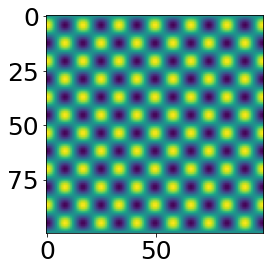

In [240]:
x_plt = np.linspace(-1,1,100)
X_p, Y_p = np.meshgrid(x_plt,x_plt)
x_u = model.data_axes([x_plt,x_plt]).T
plt.imshow(model(x_u).T[0].reshape(100,100).detach().numpy())
e_1 = np.mean(abs(gt(X_p,Y_p,lam) - model(x_u).T[0].reshape(100,100).detach().numpy()))
e_infty = np.max(abs(gt(X_p,Y_p,lam) - model(x_u).T[0].reshape(100,100).detach().numpy()))
print('e_1 = '+str(e_1),'e_infty = '+str(e_infty))

In [241]:
metric_2d_rec(gXY)
gXY.shape,dmn_rec.shape

(torch.Size([676]), torch.Size([676, 961]))

In [215]:
# Analytic Gradient Flow
start = time.time()
hk = [0,-1,-2,-3,-4, -5, -6,-7,-8,-9,-10]
def u_k (k,j):
    sob_2d.set_s(hk[j])
    metric_2d = sob_2d.metric(weak=True)
    KsK = 2*matmul(dmn.T, K[k].T, metric_2d(matmul(K[k], dmn)))\
            +2*matmul(dmn_rec.T, metric_2d_rec(dmn_rec))

    Ksf = 2*matmul(dmn.T, K[k].T, metric_2d(fXY[k]))\
            +2*matmul(dmn_rec.T, metric_2d_rec(gXY))
    w = matmul(KsK.inverse(), Ksf)
    model.set_weights(w)
    x_plt = np.linspace(-1,1,100)
    X_p, Y_p = np.meshgrid(x_plt,x_plt)
    x_u = model.data_axes([x_plt,x_plt]).T
    e_1 = np.mean(abs(gt(X_p,Y_p,lam) - model(x_u).T[0].reshape(100,100).detach().numpy()))
    e_infty = np.max(abs(gt(X_p,Y_p,lam) - model(x_u).T[0].reshape(100,100).detach().numpy()))
    return e_1
e1_exp = [[u_k(k,j) for j in range(len(hk))] for k in range(len(K))]
end = time.time()
print('time consumption: %.2fs' % (end-start))

time consumption: 154.56s


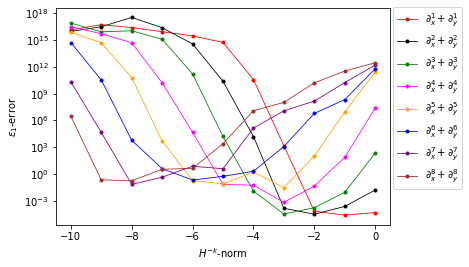

In [153]:
plt.semilogy(hk,e1_exp[0],label = "$\partial_x^{1}+\partial_y^{1}$", marker = '.',color = 'red')
plt.semilogy(hk,e1_exp[1],label = "$\partial_x^{2}+\partial_y^{2}$", marker = '.',color = 'black')
plt.semilogy(hk,e1_exp[2],label = "$\partial_x^{3}+ \partial_y^{3}$", marker = '.',color = 'green')
plt.semilogy(hk,e1_exp[3],label = "$\partial_x^{4}+ \partial_y^{4}$", marker = '.',color = 'fuchsia')
plt.semilogy(hk,e1_exp[4],label = "$\partial_x^{5}+ \partial_y^{5}$", marker = '.',color = 'orange')
plt.semilogy(hk,e1_exp[5],label = "$\partial_x^{6}+ \partial_y^{6}$", marker = '.',color = 'blue')
plt.semilogy(hk,e1_exp[6],label = "$\partial_x^{7}+ \partial_y^{7}$", marker = '.',color = 'purple')
plt.semilogy(hk,e1_exp[7],label = "$\partial_x^{8}+ \partial_y^{8}$", marker = '.',color = 'brown')

plt.xlabel("$H^{-k}$-norm")
plt.ylabel("$\epsilon_1$-error")

#plt.semilogy(hk,e1_exp[5],label = "dx6")
plt.legend(loc='upper right',bbox_to_anchor=(1.23, 1.025))


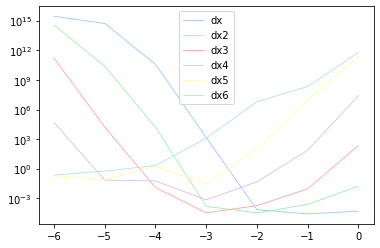

In [540]:
plt.semilogy(hk,e1_exp[0],label = "dx")
plt.semilogy(hk,e1_exp[1],label = "dx2")
plt.semilogy(hk,e1_exp[2],label = "dx3")
plt.semilogy(hk,e1_exp[3],label = "dx4")
plt.semilogy(hk,e1_exp[4],label = "dx5")
plt.semilogy(hk,e1_exp[5],label = "dx6")
plt.legend()

In [538]:
def closure(optim):
        return loss

In [500]:
n_epochs   = 1000
lamb  = 1
losses_bc  = [];
losses_reg = [];
params = [{'params': model.parameters()}]
optimizer = torch.optim.LBFGS(params)
milestones = [[10000,20000]]
#scheduler = MultiStepLR(optimizer, milestones[0], gamma=0.1)
k=0
loss =100
def training(model,epochs,k):
    params = [{'params': model.parameters()}]
    optimizer = torch.optim.LBFGS(params)
    model.set_weights(torch.zeros(len(params)))
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        #l_pde   = crit_pde(uhat)
        #l_pde = torch.sum(((eq1(uhat_1,uhat_2,p_e)*w_2d)**2))
        #l_pde += torch.sum(((eq2(uhat_1,uhat_2,p_e)*w_2d)**2))
        #l_pde += torch.sum(((eq3(uhat_1,uhat_2,p_e)*w_2d)**2))
        uhat = model(dmn).T[0]
        l_pde = crit_dmn(uhat,k)
        l_rec = crit_rec(model(dmn_rec).T[0])

        loss = l_pde + l_rec
        #with torch.no_grad():
        #    if epoch%100 == 0:
        #        lam_grad = torch.max(l_pde)
        #        lam_b = 1#torch.min((l1_bc+l2_bc))3
        #losses_bc.append(l_bc.item())
        losses_reg.append(l_pde.item())

        loss.backward()
        #optimizer_u1.step()
        #optimizer_u2.step()
        optimizer.step(
                    lambda: closure(
                        optimizer,
                    ))
    return model
u_p = training(model,1000,0)

In [242]:
#Implicit Euler Analysis
start = time.time()
hk = [0,-1,-2,-3,-4, -5, -6,-7,-8,-9,-10,-11,-12]
def u_k_IE (k,j):
    sob_2d.set_s(hk[j])
    metric_2d = sob_2d.metric(weak=True)
    gradLrec =2*matmul(dmn.T, metric_2d_rec(dmn))
    rhs_rec = 2*matmul(dmn.T, metric_2d_rec(gXY))
    rhs_pde = 2*matmul(dmn.T, K[k].T, metric_2d(fXY[k]))
    gradLpde = 2*matmul(dmn.T, K[k].T, metric_2d(matmul(K[k], dmn)))
    grad_inv = (torch.eye(len(dmn.T))+gradLpde+gradLrec).inverse()
    ####
    w_0 = torch.zeros(len(list(model.parameters())[0][0]))
    w_t = w_0
    dt = 0.001
    for k in range(1000):
            #lam_p = n_x+n_y+1
        #rhs_p = 2*torch.matmul(K[k].T,lam_p*gt_*w)
        w_t = torch.matmul(grad_inv,(w_t+rhs_pde+rhs_rec))
        #w_t = w_t + dt* ((gradLrec+gradLpde)@w_t + rhs_rec+ rhs_pde)
    
    model.set_weights(w_t)
    ####
    x_plt = np.linspace(-1,1,100)
    X_p, Y_p = np.meshgrid(x_plt,x_plt)
    x_u = model.data_axes([x_plt,x_plt]).T
    e_1 = np.mean(abs(gt(X_p,Y_p,lam) - model(x_u).T[0].reshape(100,100).detach().numpy()))
    e_infty = np.max(abs(gt(X_p,Y_p,lam) - model(x_u).T[0].reshape(100,100).detach().numpy()))
    return e_1
e1_exp = [[u_k(k,j) for j in range(len(hk))] for k in range(len(K))]

In [260]:
folder = r'Results/'
with open(folder+'hk_analysis.npy', 'wb') as f:
    np.save(f, e1_exp)

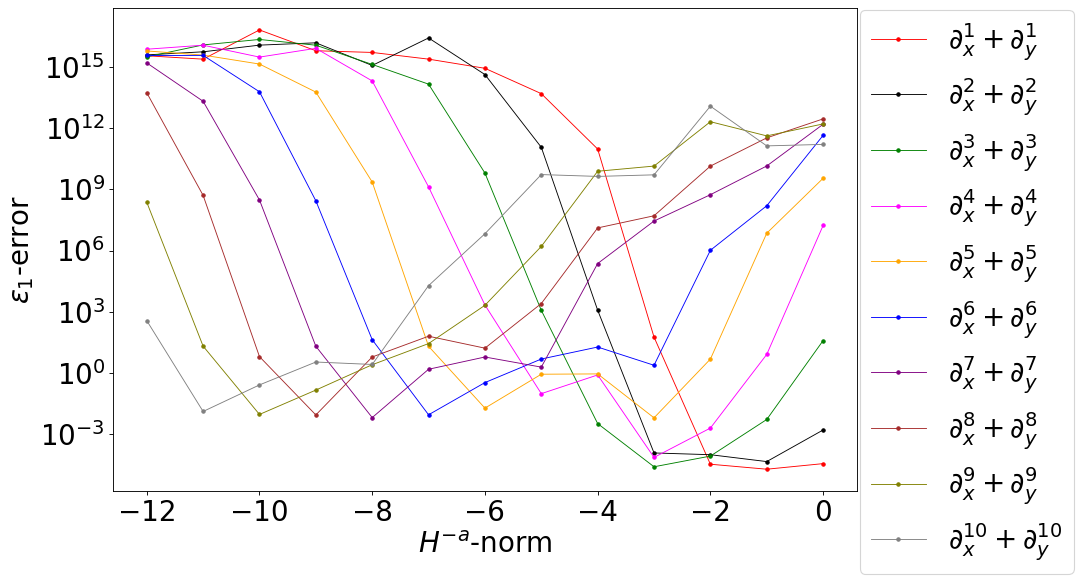

In [258]:
import matplotlib
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)
matplotlib.rcParams.update({'font.size': 25})
plt.semilogy(hk,e1_exp[0],label = "$\partial_x^{1}+\partial_y^{1}$", marker = '.',color = 'red')
plt.semilogy(hk,e1_exp[1],label = "$\partial_x^{2}+\partial_y^{2}$", marker = '.',color = 'black')
plt.semilogy(hk,e1_exp[2],label = "$\partial_x^{3}+ \partial_y^{3}$", marker = '.',color = 'green')
plt.semilogy(hk,e1_exp[3],label = "$\partial_x^{4}+ \partial_y^{4}$", marker = '.',color = 'fuchsia')
plt.semilogy(hk,e1_exp[4],label = "$\partial_x^{5}+ \partial_y^{5}$", marker = '.',color = 'orange')
plt.semilogy(hk,e1_exp[5],label = "$\partial_x^{6}+ \partial_y^{6}$", marker = '.',color = 'blue')
plt.semilogy(hk,e1_exp[6],label = "$\partial_x^{7}+ \partial_y^{7}$", marker = '.',color = 'purple')
plt.semilogy(hk,e1_exp[7],label = "$\partial_x^{8}+ \partial_y^{8}$", marker = '.',color = 'brown')
plt.semilogy(hk,e1_exp[8],label = "$\partial_x^{9}+ \partial_y^{9}$", marker = '.',color = 'olive')
plt.semilogy(hk,e1_exp[9],label = "$\partial_x^{10}+ \partial_y^{10}$", marker = '.',color = 'gray')

plt.xlabel("$H^{-a}$-norm")
plt.ylabel("$\epsilon_1$-error")

#plt.semilogy(hk,e1_exp[5],label = "dx6")
plt.legend(loc='upper right',bbox_to_anchor=(1.31, 1.025))
folder = r'Results/'
plt.savefig(folder + 'Negative_Sob_Analysis_10.png',bbox_inches='tight')

In [541]:
def u_k_NN (k,j):
    sob_2d.set_s(hk[j])
    metric_2d = sob_2d.metric(weak=True)
    model.set_weights(torch.zeros(len(params)))
    u_p = training(model,1000,k)
    ####
    x_plt = np.linspace(-1,1,100)
    X_p, Y_p = np.meshgrid(x_plt,x_plt)
    x_u = u_p.data_axes([x_plt,x_plt]).T
    e_1 = np.mean(abs(gt(X_p,Y_p,lam) - u_p(x_u).T[0].reshape(100,100).detach().numpy()))
    e_infty = np.max(abs(gt(X_p,Y_p,lam) - u_p(x_u).T[0].reshape(100,100).detach().numpy()))
    return e_1
e1_exp = [[u_k_NN(k,j) for j in range(len(hk))] for k in range(len(K))]
end = time.time()

In [542]:
u_k_NN(0,0)

0.0009638171675395334

In [571]:
e0_f = np.nan_to_num(e1_exp[0],nan=1)[0:5]
e1_f = np.nan_to_num(e1_exp[1],nan=1)[0:5]
e2_f = np.nan_to_num(e1_exp[2],nan=1)[0:5]
e3_f = np.nan_to_num(e1_exp[3],nan=1)[0:5]
e4_f = np.nan_to_num(e1_exp[4],nan=1)[0:5]
e5_f = np.nan_to_num(e1_exp[5],nan=1)[0:5]

hk_p = hk[0:5]

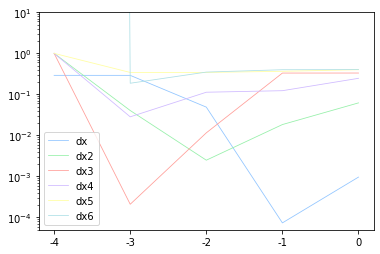

In [577]:
plt.semilogy(hk_p,e0_f,label = "dx")
plt.semilogy(hk_p,e1_f,label = "dx2")
plt.semilogy(hk_p,e2_f,label = "dx3")
plt.semilogy(hk_p,e3_f,label = "dx4")
plt.semilogy(hk_p,e4_f,label = "dx5")
plt.semilogy(hk_p,e5_f,label = "dx6")
plt.xticks(hk_p, hk_p)
plt.ylim(0.00005,10)
plt.legend()

In [142]:
np.nan_to_num(e1_exp[0],0),

(array([9.22940245e-04, 1.49064982e-05, 1.45991534e-05, 1.59678274e-05,
        1.60177135e-05]),)

## Conjugate Gradient 

In [ ]:
plt.plot(e1_exp)

start = time.time()
w = torch.tensor(scipy.sparse.linalg.cg(np.array(KsK), np.array(Ksf))[0])
model.set_weights(w)
end = time.time()
print('time consumption: %.2fs' % (end-start))

## LBFGS Optimizer

### Benchmarks

In [22]:
# Plot Losses
#solver.plot_losses(lower=0, upper=-1)

e_1 = 1.0467331923261713e-05 e_infty = 0.0025141054483060303


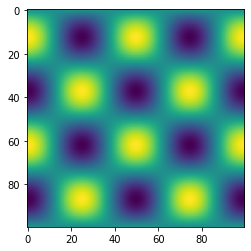

In [122]:
x_plt = np.linspace(-1,1,100)
X_p, Y_p = np.meshgrid(x_plt,x_plt)
x_u = model.data_axes([x_plt,x_plt]).T
plt.imshow(u_p(x_u).T[0].reshape(100,100).detach().numpy())
e_1 = np.mean(abs(gt(X_p,Y_p,lam) - model(x_u).T[0].reshape(100,100).detach().numpy()))
e_infty = np.max(abs(gt(X_p,Y_p,lam) - model(x_u).T[0].reshape(100,100).detach().numpy()))
print('e_1 = '+str(e_1),'e_infty = '+str(e_infty))

In [581]:
# Evaluate
_, _ = solver.eval()

TypeError: gt() missing 1 required positional argument: 'lam'

In [ ]:
# Plots
suffix = None#"poisson2d"
solver.plot_model(suffix=suffix)
solver.plot_gt(suffix=suffix)
solver.plot_abs_err(suffix=suffix)

In [ ]:
# Errors
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')

In [ ]:
# Errors
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')